In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from scipy.linalg import expm

import pennylane as qml
from pennylane import numpy as np

from openfermion.transforms import get_sparse_operator
from openfermion.utils import get_ground_state

from pyquil.wavefunction import Wavefunction

import sys
sys.path.append('../QVarCircuit/')
from entanglement_capability import *

In [2]:
name ='h2';charge = 0;multiplicity=1;basis= 'sto-3g';geometry = 'h2.xyz';
h, nr_qubits = qml.qchem.generate_hamiltonian(
    name,
    geometry,
    charge,
    multiplicity,
    basis,
    mapping='jordan_wigner',
    n_active_orbitals=2,
    n_active_electrons=2,
)
print(nr_qubits)

4


/anaconda2/envs/py37/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/anaconda2/envs/py37/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


In [3]:
type(h)

pennylane.vqe.vqe.Hamiltonian

In [4]:
qop = qml.qchem._terms_to_qubit_operator(h.coeffs, h.ops)

In [5]:
# Get sparse (scipy.sparse.csc) representation
sparse_operator = get_sparse_operator(qop)

# Diagonalize and store exact energies
g_energy, g_state = get_ground_state(sparse_operator)

In [6]:
g_energy

-1.136189454065922

In [7]:
g_wfn = Wavefunction(g_state)

In [8]:
print(g_wfn)

(-0.0976476575+0.0377071543j)|0011> + (0.9277387555-0.3582511787j)|1100>


In [9]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1.j],[1.j,0]])

In [10]:
class Parameterized_iSWAP(qml.operation.Operation):
    num_params = 1
    num_wires = 2
    par_domain = "R"
    grad_method = "A"
    generator = [np.kron(X, X) + np.kron(Y, Y), -0.5]
    
    @staticmethod
    def _matrix(*params):
        return np.array([[1, 0, 0, 0], 
                         [0, np.cos(params[0]), -1j*np.sin(params[0]), 0], 
                         [0, -1j*np.sin(params[0]), np.cos(params[0]), 0],
                         [0, 0, 0, 1]])

    
class CPHASE(qml.operation.Operation):
    num_params = 1
    num_wires = 2
    par_domain = "R"
    grad_method = "A"
    generator = [np.diag([0,0,0,1]), -0.25]
    
    @staticmethod
    def _matrix(*params):
        return np.array([[1, 0, 0, 0], 
                       [0, 1, 0, 0], 
                       [0, 0, 1, 0],
                       [0, 0, 0, np.exp(-1.j*params[0])]])

In [11]:
class fSimGate(qml.operation.Operation):
    """Fermionic Simulation gate from:
    https://arxiv.org/pdf/1910.11333.pdf
    """
    num_params = 2
    num_wires = 2
    par_domain = "R"
    grad_method = "A"

    @staticmethod
    @qml.template
    def decomposition(theta, phi, wires):
        """Perform the gate decomposition from the paper"""
        qml.inv(Parameterized_iSWAP(theta, wires=[wires[0], wires[1]]))
        CPHASE(phi, wires=[wires[0], wires[1]])

In [12]:
dev = qml.device("default.qubit", wires=4)

dev.operations.update({"Parameterized_iSWAP", "CPHASE"})

In [25]:
def circuit(params, wires=[0,1,2,3]):
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[1])

    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    fSimGate(params[2],params[3], wires=[wires[0],wires[1]])
    qml.RZ(params[4], wires=wires[0])
    qml.RZ(params[5], wires=wires[1])
    
    qml.RX(params[6], wires=wires[2])
    qml.RX(params[7], wires=wires[3])
    fSimGate(params[8],params[9], wires=[wires[2],wires[3]])
    qml.RZ(params[10], wires=wires[2])
    qml.RZ(params[11], wires=wires[3])
    
    qml.RX(params[12], wires=wires[1])
    qml.RX(params[13], wires=wires[2])
    fSimGate(params[14],params[15], wires=[wires[1],wires[2]])
    qml.RZ(params[16], wires=wires[1])
    qml.RZ(params[17], wires=wires[2])

In [14]:
initial_params = np.random.uniform(low=0, high=4*np.pi, size=18)

In [15]:
qnodes = qml.map(circuit, h.ops, dev, measure='expval')
cost = qml.dot([h.coeffs], qnodes)

In [16]:
cost(initial_params)

array([-0.57268122])

In [17]:
max_iter = 200
step_size = 0.2
conv_tol = 1e-6

params = initial_params
prev_energy = cost(initial_params)[0]
# prev_mw_measure = compute_Q(dev.state, N=4)

energycost = [prev_energy]
# mwcost = [prev_mw_measure]

for n in range(max_iter):
    gradient = qml.grad(cost, argnum=[0])
    grad_at_point = [float(i) for i in gradient(params)[0]]
    
    params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), grad_at_point)
    
    energy = cost(params)[0]
    energycost.append(energy)
    # mwcost.append(compute_Q(dev.state, N=4))
    
    conv = abs(energy - prev_energy)
        
    if n % 20 == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))
    
    if conv <= conv_tol:
        break
        
    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', n)

Iteration = 0,  Energy = -0.57268122 Ha,  Convergence parameter = 0.00000000 Ha

Final convergence parameter = 0.00000000 Ha
Final value of the ground-state energy = -0.57268122 Ha

Final circuit parameters = 
 [ 8.43513699  9.14814214  4.50592075 10.89555255  6.89455961  1.7324547
  7.84751932  5.15842034  8.84141978  6.19515225  4.53250122 10.78596756
  5.29027092  7.90567057  8.24814838  2.38622934  0.60314111  9.50569249]
Number of iterations =  0


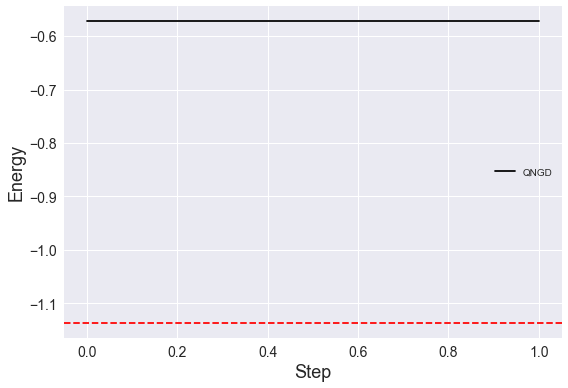

In [18]:
plt.style.use("seaborn")
plt.plot(energycost, "k-", label="QNGD")

plt.axhline(y=g_energy, color='r', linestyle='--')


plt.ylabel("Energy", fontsize=18)
plt.xlabel("Step", fontsize=18)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.legend()

plt.tight_layout()

In [19]:
# plt.style.use("seaborn")
# plt.plot(mwcost, "k-", label="QNGD")

# plt.ylabel("Meyer-Wallach measure", fontsize=18)
# plt.xlabel("Step", fontsize=18)

# plt.yticks(fontsize=14)
# plt.xticks(fontsize=14)

# plt.legend()

# plt.tight_layout()

In [20]:
dE = energy - g_energy
print(dE)

0.563508233139566


In [21]:
# qnodes[0].draw()

In [22]:
vqe_wfn = Wavefunction(dev.state)
print(vqe_wfn)

(0.5332763146-0.7537442844j)|1010> + (-0.1610804737-0.3486244497j)|1100>


In [23]:
vqe_wfn.pretty_print_probabilities()

{'1010': 0.85, '1100': 0.15}

In [24]:
fid = np.absolute(np.dot(np.conjugate(np.transpose(g_state)), vqe_wfn.amplitudes))**2
print(fid)

0.14586993824317826
